In [1]:
import os,sys
os.chdir('../')
sys.path.append('./src/probability')
sys.path.append('./src/data')
sys.path.append('./src/events')
from event_processing import to_hist
from importerDC import get_aeff_df_dc, get_systematics, get_DC_MC,get_DC_MC_2018,DC2018_event_data, DC2015_event_data
from processerDC import interpolate_flux_DC, process_aeff, get_flux
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')


In [4]:
interp_flux = interpolate_flux_DC()
df_list = get_aeff_df_dc()
e_list = process_aeff(df_list[0])
ebar_list = process_aeff(df_list[1])
mu_list = process_aeff(df_list[2])
mubar_list = process_aeff(df_list[3])
tau_list = process_aeff(df_list[4])
taubar_list = process_aeff(df_list[5])
nc_list = process_aeff(df_list[6])
ncbar_list = process_aeff(df_list[7])

In [5]:
Ereco = 10**np.linspace(0.80,1.75,9)
zreco = np.linspace(-1,0,9)#[0:-1]
livetime = 953*24*3600

In [6]:
e_res = []
for aeff_df in e_list:
    aeff_df['flux'] = get_flux('e',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['volume'] = (aeff_df.Emax-aeff_df.Emin)*(aeff_df.zmax-aeff_df.zmin)     *aeff_df.aeff_E*aeff_df.DOMeff*aeff_df.ICEeff*aeff_df.flux
    e_res.append(np.sum(aeff_df.volume)*livetime*2*np.pi)
e_res = np.array(e_res).reshape(8,8)

ebar_res = []
for aeff_df in ebar_list:
    aeff_df['flux'] = get_flux('ebar',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['volume'] = (aeff_df.Emax-aeff_df.Emin)*(aeff_df.zmax-aeff_df.zmin)     *aeff_df.aeff_EBar*aeff_df.flux*aeff_df.DOMeff*aeff_df.ICEeff
    ebar_res.append(np.sum(aeff_df.volume)*livetime*2*np.pi)
ebar_res = np.array(ebar_res).reshape(8,8)

mu_res = []
for aeff_df in mu_list:
    aeff_df['flux'] = get_flux('m',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['volume'] = (aeff_df.Emax-aeff_df.Emin)*(aeff_df.zmax-aeff_df.zmin)     *aeff_df.aeff_Mu*aeff_df.flux*aeff_df.DOMeff*aeff_df.ICEeff
    mu_res.append(np.sum(aeff_df.volume)*livetime*2*np.pi)
mu_res = np.array(mu_res).reshape(8,8)

mubar_res = []
for aeff_df in mubar_list:
    aeff_df['flux'] = get_flux('mbar',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['volume'] = (aeff_df.Emax-aeff_df.Emin)*(aeff_df.zmax-aeff_df.zmin)     *aeff_df.aeff_Mubar*aeff_df.flux*aeff_df.DOMeff*aeff_df.ICEeff
    mubar_res.append(np.sum(aeff_df.volume)*livetime*2*np.pi)
mubar_res = np.array(mubar_res).reshape(8,8)

nc_res = []
for aeff_df in nc_list:
    aeff_df['flux_e'] = get_flux('e',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['flux_m'] = get_flux('m',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['volume'] = (aeff_df.Emax-aeff_df.Emin)*(aeff_df.zmax-aeff_df.zmin)     *aeff_df.DOMeff*aeff_df.ICEeff*aeff_df.aeff_X*(aeff_df.flux_e + aeff_df.flux_m)
    nc_res.append(np.sum(aeff_df.volume)*livetime*2*np.pi)
nc_res = np.array(nc_res).reshape(8,8)

ncbar_res = []
for aeff_df in ncbar_list:
    aeff_df['flux_ebar'] = get_flux('ebar',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['flux_mbar'] = get_flux('mbar',10**aeff_df.E_avg,aeff_df.z_avg,interp_flux)
    aeff_df['volume'] = (aeff_df.Emax-aeff_df.Emin)*(aeff_df.zmax-aeff_df.zmin)     *aeff_df.DOMeff*aeff_df.ICEeff*aeff_df.aeff_XBar*(aeff_df.flux_ebar + aeff_df.flux_mbar)
    ncbar_res.append(np.sum(aeff_df.volume)*livetime*2*np.pi)
ncbar_res = np.array(ncbar_res).reshape(8,8)


In [58]:
res = mu_res+mubar_res+e_res+ebar_res#+nc_res+ncbar_res
#Får bättre fit med bara mu ...

In [59]:
MC_list = get_DC_MC()

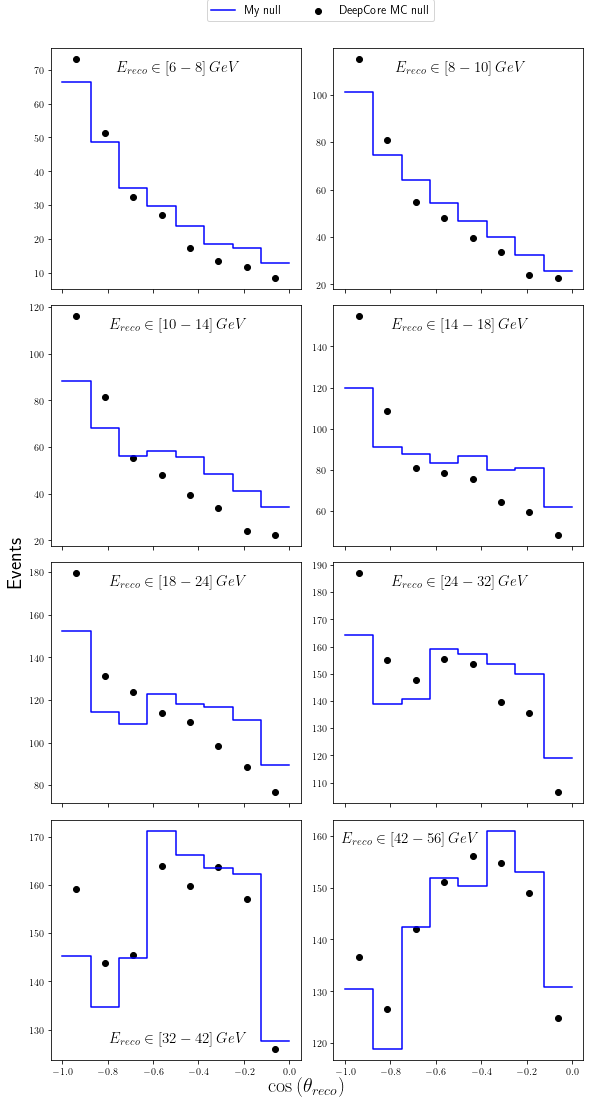

In [60]:
from scipy.optimize import leastsq 
fig, ax = plt.subplots(4,2, sharex=True, squeeze=True, figsize=(8,15))
ax = ax.flatten()
zreco_midpoints = zreco[0:-1] +np.diff(zreco)/2
title_pos = [(0.5,0.88)]*8
title_pos[6] = (0.5,0.05)
title_pos[7] = (0.3,0.88)
Ebins = Ereco.astype(int)
for i in range(8):
    norms = leastsq(lambda x:x*res[:,i]-MC_list[i], x0=10)[0]
    res_hist = to_hist(res[:,i]*norms)
    MC_hist = to_hist(MC_list[i])
    ax[i].step(zreco, res_hist, where='post', label='My null', color='blue')
    ax[i].scatter(zreco_midpoints, MC_list[i], label='DeepCore MC null', color='black')
    ax[i].set_title(rf'$E_{{reco}} \in [{Ebins[i]}-{Ebins[i+1]}] \, GeV$',x = title_pos[i][0], y = title_pos[i][1], fontsize=15)
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.35,0.98), ncol=2, fontsize=12)
fig.suptitle(r'$\cos{(\theta_{{reco}})}$',y=0.01,fontsize=20)
fig.tight_layout()
_=ax[4].set_ylabel('Events', fontsize=20, x=-1.1,y=1)

In [61]:
res_E = np.sum(res,axis=0)
res_z = np.sum(res,axis=1)
MC2015_E = np.sum(MC_list,axis=1)
MC2015_z = np.sum(MC_list,axis=0)
MC2018_E = get_DC_MC_2018().events

data2018_E = np.sum(DC2018_event_data(),axis=0).values
data2018_z = np.sum(DC2018_event_data(),axis=1).values
data2015_E = np.sum(DC2015_event_data().events,axis=0).values
data2015_z = np.sum(DC2015_event_data().events,axis=1).values


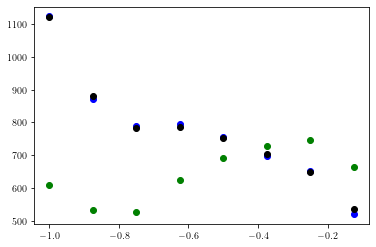

In [62]:

norms = leastsq(lambda x:x*res_z-MC2015_z, x0=10)[0]
plt.scatter(zreco[0:-1], res_z*norms, label='My null', color='blue')
plt.scatter(zreco[0:-1], MC2015_z, label='DeepCore MC null', color='black')
plt.scatter(zreco[0:-1], data2015_z, label='DeepCore MC data', color='green')

(0.0, 2000.0)

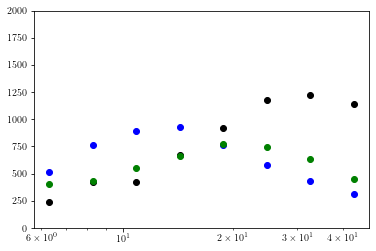

In [63]:
norms = leastsq(lambda x:x*res_E-MC2015_E, x0=10)[0]
plt.scatter(Ereco[0:-1], res_E*norms, label='My null', color='blue')
plt.scatter(Ereco[0:-1], MC2015_E, label='DeepCore MC null', color='black')
plt.scatter(Ereco[0:-1], MC2018_E*0.25, label='DeepCore MC null', color='green')
plt.xscale('log')
plt.ylim((0,2000))